**Подключение библиотек и скриптов**

In [92]:
#!pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [233]:
import pandas as pd
import numpy as np
import warnings


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
#from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, roc_auc_score, precision_score, precision_recall_curve, roc_curve

import itertools

#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sns
#import itertoy_test, predsols

from scipy.stats import boxcox, probplot
import matplotlib.pyplot as plt

from datetime import datetime

In [80]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [255]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [111]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [254]:
def tfpr_cof_matrix(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}
    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

In [85]:
RANDOM_STATE = 42

### Загрузка данных<a class="anchor" id="load_data"></a>

In [4]:
# input
FEATURES_PATH = 'data/features.csv'
DATA_TRAIN_PATH = 'data/data_train.csv'
DATA_TEST_PATH = 'data/data_test.csv'
#output
DATA_TRAIN_MERGE_PATH = 'data/data_train_merge.csv'
DATA_TEST_MERGE_PATH = 'data/data_test_merge.csv'

**Описание базового датасета**

**Данные:** 
train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:

●	data_train.csv: id, vas_id, buy_time, target

●	features.csv.zip: id, <feature_list> 

**Тестовый набор:**

●	data_test.csv: id, vas_id, buy_time

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.

In [6]:
df_train = pd.read_csv(DATA_TRAIN_MERGE_PATH)

In [88]:
df_train.head() 

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,3532789,1.0,2018-07-09 01:00:00,0.0,-30.349971,-139.569112,-44.290786,-192.176798,-49.708246,-213.28179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,167964,4.0,2018-07-09 01:00:00,0.0,280.330029,47.670888,266.389214,-4.936798,265.211754,28.99821,...,-977.373846,-613.770792,-25.996269,-37.630448,-237.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0
2,4236220,1.0,2018-07-09 01:00:00,0.0,-96.799971,49.440888,-110.740786,-3.166798,-116.158246,-24.27179,...,-903.373846,-539.770792,-25.996269,-37.630448,-290.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
3,3883492,4.0,2018-07-09 01:00:00,0.0,-92.139971,-46.319112,-106.080786,61.243202,-111.498246,40.13821,...,-969.373846,-613.770792,-24.996269,-37.630448,1699.252276,-20.832889,1.305572,-9.175933,-0.45614,1.0
4,2847225,1.0,2018-07-09 01:00:00,0.0,464.210029,428.250888,450.269214,375.643202,444.851754,354.53821,...,6808.626154,6258.229208,-18.996269,58.369552,1.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


**Выделение целевой переменной и групп признаков**

In [10]:
X = df_train .drop(columns = ['id','target', 'buy_time'])
y = df_train ['target']

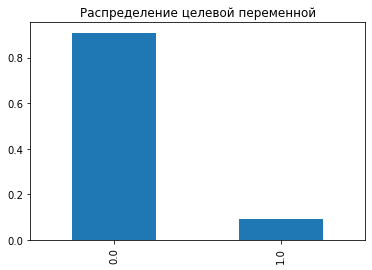

In [37]:
(y.value_counts()/y.shape).plot(kind='bar', title='Распределение целевой переменной');

Наблюдаем разбалансировку классов

In [38]:
y.value_counts()/y.shape

0.0    0.909252
1.0    0.090748
Name: target, dtype: float64

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [12]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [32]:
X_nunique

vas_id        8
0         32842
1         84457
2         40195
3         99572
          ...  
248        1583
249         213
250        1398
251         209
252          19
Length: 254, dtype: int64

##### Всего признаков

In [31]:
all_features = set(X_nunique.index.tolist())
len(all_features)

254

##### Константные признаки

In [14]:
const_features = set(X_nunique[X_nunique == 1].index.tolist())
len(const_features)

##### Вещественные признаки

In [15]:
numeric_features = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
numeric_features = set(numeric_features[numeric_features > 0].index.tolist())
other_features = all_features - (numeric_features | const_features)
len(numeric_features)

##### Бинарные признаки

In [16]:
binary_features = set(X.loc[:, other_features].columns[(
                      (X.loc[:, other_features].max() == 1) & \
                      (X.loc[:, other_features].min() == 0) & \
                      (X.loc[:, other_features].isnull().sum() == 0))])
len(binary_features)

In [17]:
other_features = other_features - binary_features

##### Категориальные признаки 
Определим максимальное количество уникальных значений среди категориальных признаков = 20

In [19]:
categorical_features = set(X_nunique.loc[other_features][X_nunique.loc[other_features] <= 20].index.tolist())
len(categorical_features)

##### Прочие признаки

In [20]:
other_features = other_features - categorical_features
len(other_features)

0

##### Удалим константные признаки

In [21]:
X = X.drop(columns = const_features)

In [22]:
# в transformers ColumnTransformer нельзя использовать 
#список строк имен столбцов для numeric_features или categorical_features
# сделаем следующую обработку
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = RANDOM_STATE)

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Pipeline BaseLine** 

In [23]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

**Pipeline обработки признаков**

In [24]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

**Логистическая регрессия**

Best Threshold=0.644336, F-Score=nan, Precision=0.000, Recall=0.000
Confusion matrix, without normalization
[[122173    503]
 [ 12050    153]]


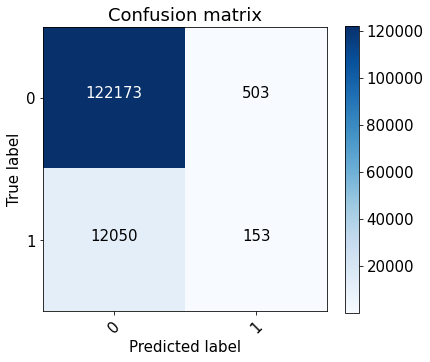

Wall time: 7min 45s


In [245]:
%%time
model_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE,  
                                                     #   max_iter=100
                                                       ))])
model_logreg.fit(X_train, y_train)
preds_logreg = model_logreg.predict_proba(X_test)[:, 1]
tfpr_cof_matrix(y_test, preds_logreg)

**Случайный лес**

Best Threshold=0.958571, F-Score=nan, Precision=0.000, Recall=0.000
Confusion matrix, without normalization
[[121722    954]
 [ 12113     90]]


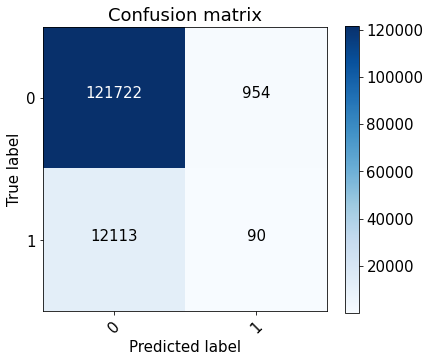

Wall time: 14min 17s


In [246]:
%%time
model_rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))])
model_rfc.fit(X_train, y_train)
preds_rfc = model_rfc.predict_proba(X_test)[:, 1]
tfpr_cof_matrix(y_test, preds_rfc)

**Дерево решений**

Best Threshold=0.400000, F-Score=0.297, Precision=0.280, Recall=0.315
Confusion matrix, without normalization
[[113319   9357]
 [  8490   3713]]


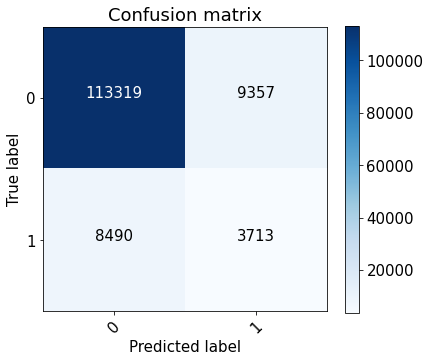

Wall time: 6min 3s
Parser   : 119 ms


In [247]:
%%time
model_dtc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))])
model_dtc.fit(X_train, y_train)
preds_dtc = model_dtc.predict_proba(X_test)[:, 1]
tfpr_cof_matrix(y_test, preds_dtc)

**Бустинговые алгоритмы**

*XGBoost*

[18:21:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Threshold=0.168604, F-Score=0.504, Precision=0.368, Recall=0.800
Confusion matrix, without normalization
[[121263   1413]
 [ 11208    995]]


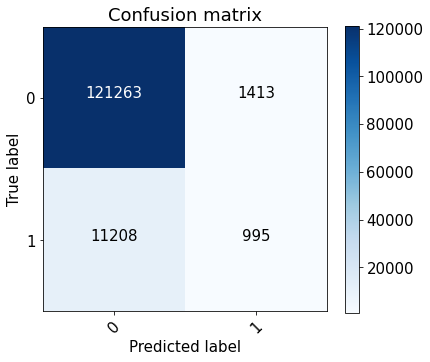

Wall time: 14min 42s


In [248]:
%%time
model_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE))])
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict_proba(X_test)[:, 1]
tfpr_cof_matrix(y_test, preds_xgb)

*LightGBM*

Best Threshold=0.744836, F-Score=nan, Precision=0.000, Recall=0.000
Confusion matrix, without normalization
[[122381    295]
 [ 11974    229]]


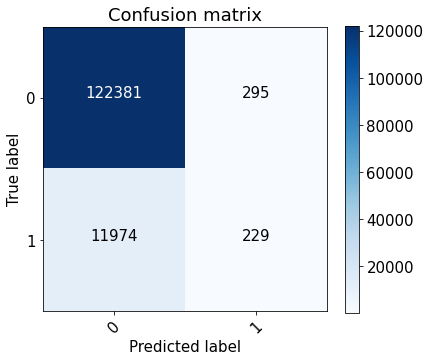

Wall time: 1min 43s


In [249]:
%%time
model_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lgbm.LGBMClassifier(n_jobs=-1, random_state=RANDOM_STATE))])
model_lgbm.fit(X_train, y_train)
preds_lgbm = model_lgbm.predict_proba(X_test)[:, 1]
tfpr_cof_matrix(y_test, preds_lgbm)

*CatBoost*

Learning rate set to 0.113174
0:	learn: 0.5565774	total: 747ms	remaining: 12m 26s
1:	learn: 0.4718978	total: 1.59s	remaining: 13m 12s
2:	learn: 0.3926638	total: 2.34s	remaining: 12m 58s
3:	learn: 0.3389426	total: 3.05s	remaining: 12m 39s
4:	learn: 0.3122908	total: 3.88s	remaining: 12m 53s
5:	learn: 0.2838930	total: 4.77s	remaining: 13m 10s
6:	learn: 0.2641884	total: 5.63s	remaining: 13m 19s
7:	learn: 0.2526924	total: 6.68s	remaining: 13m 48s
8:	learn: 0.2479286	total: 7.64s	remaining: 14m 1s
9:	learn: 0.2419842	total: 8.37s	remaining: 13m 48s
10:	learn: 0.2340587	total: 9.14s	remaining: 13m 41s
11:	learn: 0.2285875	total: 9.98s	remaining: 13m 41s
12:	learn: 0.2247240	total: 10.8s	remaining: 13m 38s
13:	learn: 0.2224507	total: 11.8s	remaining: 13m 53s
14:	learn: 0.2212773	total: 13s	remaining: 14m 16s
15:	learn: 0.2192442	total: 14.5s	remaining: 14m 54s
16:	learn: 0.2180914	total: 15.6s	remaining: 15m 1s
17:	learn: 0.2177517	total: 16.6s	remaining: 15m 4s
18:	learn: 0.2162858	total: 17.

153:	learn: 0.2078496	total: 2m 36s	remaining: 14m 18s
154:	learn: 0.2078400	total: 2m 36s	remaining: 14m 15s
155:	learn: 0.2078003	total: 2m 37s	remaining: 14m 12s
156:	learn: 0.2077796	total: 2m 38s	remaining: 14m 10s
157:	learn: 0.2077689	total: 2m 39s	remaining: 14m 7s
158:	learn: 0.2077492	total: 2m 39s	remaining: 14m 5s
159:	learn: 0.2077456	total: 2m 40s	remaining: 14m 2s
160:	learn: 0.2077422	total: 2m 41s	remaining: 13m 59s
161:	learn: 0.2077146	total: 2m 41s	remaining: 13m 57s
162:	learn: 0.2076941	total: 2m 42s	remaining: 13m 55s
163:	learn: 0.2076532	total: 2m 43s	remaining: 13m 53s
164:	learn: 0.2076196	total: 2m 45s	remaining: 13m 55s
165:	learn: 0.2075675	total: 2m 46s	remaining: 13m 58s
166:	learn: 0.2075450	total: 2m 49s	remaining: 14m 5s
167:	learn: 0.2075151	total: 2m 52s	remaining: 14m 14s
168:	learn: 0.2074759	total: 2m 56s	remaining: 14m 27s
169:	learn: 0.2074524	total: 3m	remaining: 14m 42s
170:	learn: 0.2074493	total: 3m 3s	remaining: 14m 49s
171:	learn: 0.20742

304:	learn: 0.2041977	total: 5m 3s	remaining: 11m 31s
305:	learn: 0.2041738	total: 5m 4s	remaining: 11m 30s
306:	learn: 0.2041487	total: 5m 5s	remaining: 11m 28s
307:	learn: 0.2041164	total: 5m 5s	remaining: 11m 27s
308:	learn: 0.2040774	total: 5m 6s	remaining: 11m 25s
309:	learn: 0.2040755	total: 5m 7s	remaining: 11m 24s
310:	learn: 0.2040457	total: 5m 8s	remaining: 11m 22s
311:	learn: 0.2040171	total: 5m 8s	remaining: 11m 21s
312:	learn: 0.2040164	total: 5m 9s	remaining: 11m 19s
313:	learn: 0.2039934	total: 5m 10s	remaining: 11m 17s
314:	learn: 0.2039928	total: 5m 10s	remaining: 11m 16s
315:	learn: 0.2039760	total: 5m 11s	remaining: 11m 14s
316:	learn: 0.2039453	total: 5m 12s	remaining: 11m 13s
317:	learn: 0.2039371	total: 5m 13s	remaining: 11m 11s
318:	learn: 0.2039015	total: 5m 13s	remaining: 11m 9s
319:	learn: 0.2038973	total: 5m 14s	remaining: 11m 8s
320:	learn: 0.2038688	total: 5m 15s	remaining: 11m 6s
321:	learn: 0.2038439	total: 5m 15s	remaining: 11m 5s
322:	learn: 0.2038146	t

456:	learn: 0.2006401	total: 7m 9s	remaining: 8m 29s
457:	learn: 0.2006120	total: 7m 10s	remaining: 8m 29s
458:	learn: 0.2005908	total: 7m 11s	remaining: 8m 28s
459:	learn: 0.2005708	total: 7m 11s	remaining: 8m 27s
460:	learn: 0.2005507	total: 7m 12s	remaining: 8m 25s
461:	learn: 0.2005301	total: 7m 13s	remaining: 8m 25s
462:	learn: 0.2005061	total: 7m 14s	remaining: 8m 24s
463:	learn: 0.2004872	total: 7m 15s	remaining: 8m 23s
464:	learn: 0.2004540	total: 7m 16s	remaining: 8m 22s
465:	learn: 0.2004344	total: 7m 17s	remaining: 8m 21s
466:	learn: 0.2004059	total: 7m 18s	remaining: 8m 20s
467:	learn: 0.2003887	total: 7m 19s	remaining: 8m 19s
468:	learn: 0.2003517	total: 7m 20s	remaining: 8m 18s
469:	learn: 0.2003145	total: 7m 20s	remaining: 8m 17s
470:	learn: 0.2002835	total: 7m 22s	remaining: 8m 16s
471:	learn: 0.2002546	total: 7m 23s	remaining: 8m 16s
472:	learn: 0.2002256	total: 7m 26s	remaining: 8m 17s
473:	learn: 0.2002205	total: 7m 28s	remaining: 8m 18s
474:	learn: 0.2002066	total: 

609:	learn: 0.1972137	total: 9m 27s	remaining: 6m 3s
610:	learn: 0.1971862	total: 9m 28s	remaining: 6m 2s
611:	learn: 0.1971857	total: 9m 29s	remaining: 6m
612:	learn: 0.1971617	total: 9m 29s	remaining: 5m 59s
613:	learn: 0.1971314	total: 9m 31s	remaining: 5m 59s
614:	learn: 0.1971299	total: 9m 31s	remaining: 5m 58s
615:	learn: 0.1971052	total: 9m 32s	remaining: 5m 57s
616:	learn: 0.1971048	total: 9m 33s	remaining: 5m 55s
617:	learn: 0.1970846	total: 9m 34s	remaining: 5m 54s
618:	learn: 0.1970778	total: 9m 34s	remaining: 5m 53s
619:	learn: 0.1970678	total: 9m 35s	remaining: 5m 52s
620:	learn: 0.1970416	total: 9m 35s	remaining: 5m 51s
621:	learn: 0.1970044	total: 9m 36s	remaining: 5m 50s
622:	learn: 0.1969775	total: 9m 37s	remaining: 5m 49s
623:	learn: 0.1969677	total: 9m 37s	remaining: 5m 48s
624:	learn: 0.1969667	total: 9m 38s	remaining: 5m 47s
625:	learn: 0.1969599	total: 9m 39s	remaining: 5m 45s
626:	learn: 0.1969414	total: 9m 39s	remaining: 5m 44s
627:	learn: 0.1969300	total: 9m 40

761:	learn: 0.1940351	total: 11m 23s	remaining: 3m 33s
762:	learn: 0.1940083	total: 11m 23s	remaining: 3m 32s
763:	learn: 0.1939870	total: 11m 24s	remaining: 3m 31s
764:	learn: 0.1939706	total: 11m 25s	remaining: 3m 30s
765:	learn: 0.1939510	total: 11m 25s	remaining: 3m 29s
766:	learn: 0.1939328	total: 11m 26s	remaining: 3m 28s
767:	learn: 0.1939209	total: 11m 27s	remaining: 3m 27s
768:	learn: 0.1939119	total: 11m 27s	remaining: 3m 26s
769:	learn: 0.1938798	total: 11m 28s	remaining: 3m 25s
770:	learn: 0.1938656	total: 11m 28s	remaining: 3m 24s
771:	learn: 0.1938579	total: 11m 29s	remaining: 3m 23s
772:	learn: 0.1938501	total: 11m 30s	remaining: 3m 22s
773:	learn: 0.1938264	total: 11m 30s	remaining: 3m 21s
774:	learn: 0.1938062	total: 11m 31s	remaining: 3m 20s
775:	learn: 0.1938033	total: 11m 32s	remaining: 3m 19s
776:	learn: 0.1937878	total: 11m 32s	remaining: 3m 18s
777:	learn: 0.1937580	total: 11m 33s	remaining: 3m 17s
778:	learn: 0.1937219	total: 11m 34s	remaining: 3m 17s
779:	learn

912:	learn: 0.1908230	total: 13m 28s	remaining: 1m 17s
913:	learn: 0.1907942	total: 13m 29s	remaining: 1m 16s
914:	learn: 0.1907630	total: 13m 30s	remaining: 1m 15s
915:	learn: 0.1907339	total: 13m 31s	remaining: 1m 14s
916:	learn: 0.1907151	total: 13m 32s	remaining: 1m 13s
917:	learn: 0.1906815	total: 13m 33s	remaining: 1m 12s
918:	learn: 0.1906765	total: 13m 33s	remaining: 1m 11s
919:	learn: 0.1906504	total: 13m 34s	remaining: 1m 10s
920:	learn: 0.1906280	total: 13m 35s	remaining: 1m 9s
921:	learn: 0.1906148	total: 13m 36s	remaining: 1m 9s
922:	learn: 0.1905901	total: 13m 36s	remaining: 1m 8s
923:	learn: 0.1905671	total: 13m 37s	remaining: 1m 7s
924:	learn: 0.1905459	total: 13m 38s	remaining: 1m 6s
925:	learn: 0.1905224	total: 13m 39s	remaining: 1m 5s
926:	learn: 0.1905049	total: 13m 39s	remaining: 1m 4s
927:	learn: 0.1904909	total: 13m 40s	remaining: 1m 3s
928:	learn: 0.1904640	total: 13m 41s	remaining: 1m 2s
929:	learn: 0.1904403	total: 13m 42s	remaining: 1m 1s
930:	learn: 0.190421

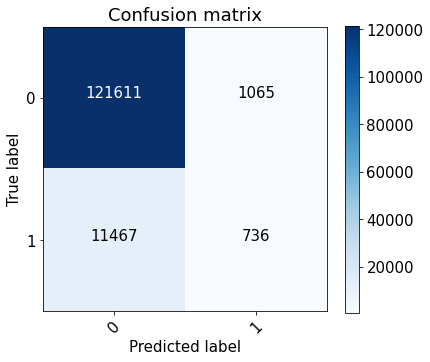

Wall time: 15min 26s


In [251]:
%%time
model_catb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', catb.CatBoostClassifier(silent=True, random_state=RANDOM_STATE))])
model_catb.fit(X_train, y_train)
preds_catb = model_catb.predict_proba(X_test)[:, 1]
tfpr_cof_matrix(y_test, preds_catb)

In [256]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    248957
         1.0       0.91      0.19      0.32     24888

    accuracy                           0.92    273845
   macro avg       0.92      0.60      0.64    273845
weighted avg       0.92      0.92      0.90    273845

TEST

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95    122676
         1.0       0.41      0.06      0.11     12203

    accuracy                           0.91    134879
   macro avg       0.66      0.53      0.53    134879
weighted avg       0.87      0.91      0.87    134879

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     121611  1065
1.0      11467   736


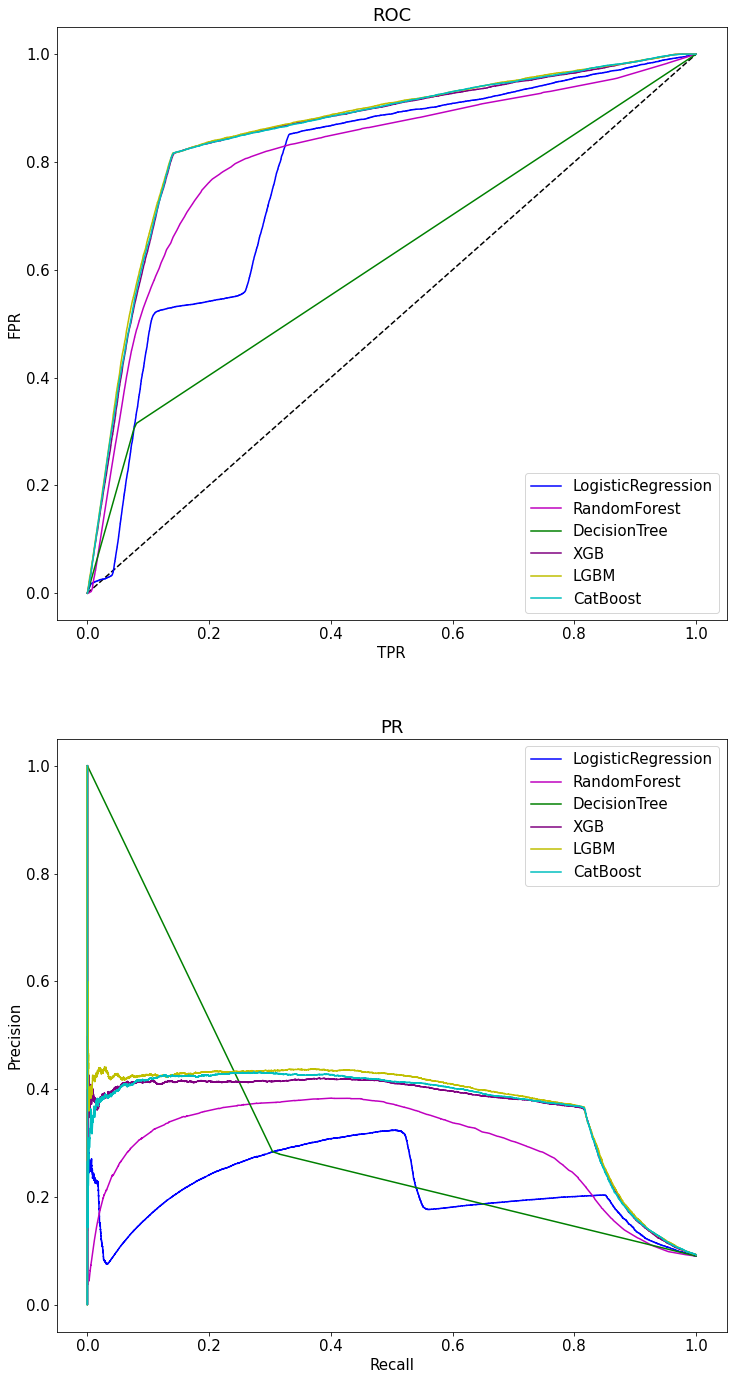

In [253]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, preds_logreg)
precision, recall, pr_thresholds = precision_recall_curve(y_test, preds_logreg)
ax1.plot(fpr, tpr, label='LogisticRegression', color='b')
ax2.plot(recall, precision, label='LogisticRegression', color='b')

fpr, tpr, roc_thresholds = roc_curve(y_test, preds_rfc)
precision, recall, pr_thresholds = precision_recall_curve(y_test, preds_rfc)
ax1.plot(fpr, tpr, label='RandomForest', color='m')
ax2.plot(recall, precision, label='RandomForest', color='m')
#print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
#print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))
fpr, tpr, roc_thresholds = roc_curve(y_test, preds_dtc)
precision, recall, pr_thresholds = precision_recall_curve(y_test, preds_dtc)
ax1.plot(fpr, tpr, label="DecisionTree", color='g')
ax2.plot(recall, precision, label="DecisionTree", color='g')

fpr, tpr, roc_thresholds = roc_curve(y_test, preds_xgb)
precision, recall, pr_thresholds = precision_recall_curve(y_test, preds_xgb)
ax1.plot(fpr, tpr, label="XGB", color='purple')
ax2.plot(recall, precision, label="XGB", color='purple')

fpr, tpr, roc_thresholds = roc_curve(y_test, preds_lgbm)
precision, recall, pr_thresholds = precision_recall_curve(y_test, preds_lgbm)
ax1.plot(fpr, tpr, label="LGBM", color='y')
ax2.plot(recall, precision, label="LGBM", color='y')

fpr, tpr, roc_thresholds = roc_curve(y_test, preds_catb)
precision, recall, pr_thresholds = precision_recall_curve(y_test, preds_catb)
ax1.plot(fpr, tpr, label="CatBoost", color='c')
ax2.plot(recall, precision, label="CatBoost", color='c')

ax1.legend(loc="lower right")
ax2.legend(loc="upper right");

### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [84]:
get_classification_report(y_train, y_train_pred>0.5, y_test, y_test_pred>0.5)

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    248957
         1.0       0.23      0.01      0.02     24888

    accuracy                           0.91    273845
   macro avg       0.57      0.50      0.49    273845
weighted avg       0.85      0.91      0.87    273845

TEST

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    122676
         1.0       0.23      0.01      0.02     12203

    accuracy                           0.91    134879
   macro avg       0.57      0.50      0.49    134879
weighted avg       0.85      0.91      0.87    134879

CONFUSION MATRIX

col_0    False  True
target              
0.0     122172   504
1.0      12049   154


In [77]:
print(classification_report(y_test, bl_y_pred >0.5 ))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    122676
         1.0       0.23      0.01      0.02     12203

    accuracy                           0.91    134879
   macro avg       0.57      0.50      0.49    134879
weighted avg       0.85      0.91      0.87    134879



In [28]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [29]:
def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    """
    Процедура вычисляет кросс-валидацию и выводит её на экрнан
    Метод cross_validate делает расчет метрики на кросс-валидации. Он разбивает выборку на фолды,
    на каждом фитит модель и предиктит на валидационном датасете.
    По всем фолдам усредняет значение метрики.
    """
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [30]:
%%time
run_cv(clf, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.77 (+/- 0.01)
Wall time: 4min 7s
